# Předzpracování dat a binární klasifikace

### Zdroj dat

Úloha se zabývá predikcí přežití pasažérů Titaniku. Používám trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Příprava datasetu

In [1]:
import pandas as pd
import numpy as np

In [45]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,NaN
1,1,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S,"Australia Fingal, ND"
2,2,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S,Belfast
3,3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,NaN
4,4,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C,"New York, NY"


In [4]:
# Zjištění základního infa o datatypech, počtu vyplněných řádků, názvů sloupců a pod.
df.info()
# Zjištění chybějících hodnot
df.isnull().sum(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      222 non-null    object 
 11  embarked   999 non-null    object 
 12  home.dest  573 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


ID             0
survived       0
pclass         0
name           0
sex            0
age          203
sibsp          0
parch          0
ticket         0
fare           1
cabin        778
embarked       1
home.dest    427
dtype: int64

In [5]:
#zjistím si kolik existuje unikátních hornot v jednotlivých sloupcích
df.nunique()

ID           1000
survived        2
pclass          3
name          999
sex             2
age            94
sibsp           7
parch           7
ticket        754
fare          249
cabin         156
embarked        3
home.dest     314
dtype: int64

## Vypořádání se s chybějícími hodnotami

Z předešlého výstupu vidíme, že několik sloubců obsahuje růzdné množství nevyplněných hodnot. Pro trénování modelu je potřeba tyto hodnoty nějak zaplnit, nebo je odstranit

### Parametr "cabin"

Sloupec "cabin" označující kajutu cestujícího je vyplněn pouze z necelé čtvrtiny. Z toho důvodu tento parametr vůbec nepoužiji, protože v kontextu celého datasetu nám nic neříká. Jako směrodatný parametr o umístění kajuty použiji parametr "pcclass", který podle mě bude stačit.

### Parametr "embarked" 

e sloupci "embarked" chybí jedna hodnota z 1000. Hodnota embarked nabývá třech hodnot, tedy šance, že ji odhadneme správně je 1/3, což není dost a tak si dovolím chybějící hodnotu nahradit -1.

### Parametr "home.dest"

V tomto posledním sloupci je uvedena cílová destinace, nebo místo bydliště cestujících. Vyplněné je ze 72%, což není dost a tak budu muset i tento sloupec při predikování vynechat.

### Parametr "fare"

U parametru znázorňující cenu lísku jsem si všimla jedné chybějící hodnoty. Tu stejně jako u sloupce "embarked" nahradím hodnotou -1

### Parametry "name"  a "ID"

Tyto dva parametry jsou pro predikování nepoužitelné. Z následujícího výpisu je vidět, že "ID" je unikátní ve 100% případů, jméno ve více než 99%  případů. Parametr "name" si tedy dovolím odstranit, parametr "ID" však nikoli, protože ho budu potřebovat při porovnávání výsledných dat. Ale jinak bych ho odstranila také. 

### Parametr "age"

Z předešlého výpisu víme, že ve sloupci "age" máme 203 chybějících hodnot, což je zhruba pětina datasetu. Odstranění řádků nepřipadá v úvahu, protože bychom přišli o velké množství dat. Věk bude pro kontext tohoto konkrétního případu nejspíš důležitý, takže nelze zanedbat. Navrhuji nejdříve věk zaokrouhlit. Zjistit nejčetnější skupinu a následně odhadnout chybějící věk na základě rozložení. 

In [46]:
def round_age(df):
    age = df["age"].copy()
    for i in range(len(age)):
        if age[i]:
            age[i] = round(age[i], -1)
    df["age"] = age.copy()
    return

def age_category(df):
    age = df["age"].copy()
    for i in range(len(age)):
        if age[i] < 20:
            age[i] = 1
        elif age[i] < 50:
            age[i] = 2
        elif age[i] >= 50:
            age[i] = 3
    df["age"] = age.copy()

age_category(df)

Po zaokrouhování, ve kterém procházím celý dataframe, takže nechci žádné chybějící řádky, mohu konečně některé z nich odstarnit. 

In [47]:
# nejdříve odstraním nepotřebné řádky
df["fare"].fillna(-1, inplace=True)
df["embarked"].fillna(-1, inplace=True)

# zde odstraňuji nepotřebné sloupce
df.drop(labels=["cabin"], axis=1, inplace=True)
df.drop(labels=["home.dest"], axis=1, inplace=True)
df.drop(labels=["name"], axis=1, inplace=True)

Pro představu o věku pasažérů si vykreslím graf znázorňující počet cestujících v dané věkové dekádě.

<AxesSubplot: title={'center': 'Number of passangers in same rounded age'}, xlabel='age'>

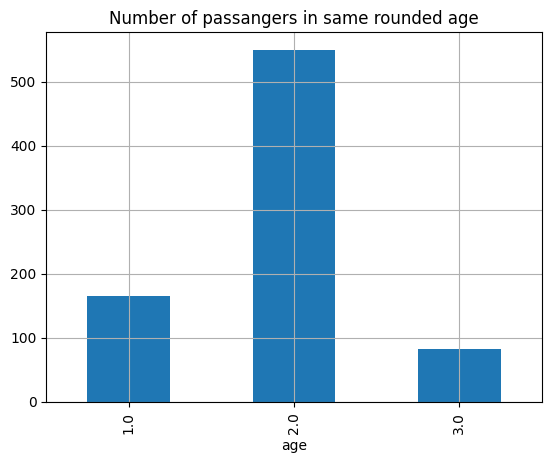

In [48]:
import matplotlib
import matplotlib.pyplot as plt

s = df.groupby('age')['ID'].nunique()
s.plot.bar(title='Number of passangers in same rounded age', grid=True)

Nyní si rozdělím původní dataset na dva - 1. obsahující vyplněné řádky "age", 2. má řádky nevyplněné. 

In [49]:
df_filled_age = df.dropna(subset=["age"]).copy()
df_filled_age["age"] = df_filled_age["age"].astype("int")
df_not_filled_age = df[df.age.isna()].copy()

Teď zkontorluji, zda vytvořené dataframy vypadají tak jak jsem chtěla, tedy df_filled_age má všechny hodnoty vyplněny, df_not_filled_age nemá vyplněnou ani jednu ve sloupci "age", ale ostatní sloupce jsou bez nulových hodnot.

In [10]:
df_filled_age.head()

,ID,survived,pclass,sex,age,sibsp,parch,ticket,fare,embarked
0,0,1,3,male,2,0,0,350043,7.7958,S
1,1,1,3,male,2,0,0,7598,8.0500,S
3,3,1,3,female,2,0,2,347742,11.1333,S
4,4,0,1,male,2,1,0,PC 17604,82.1708,C
6,6,0,1,male,2,1,0,PC 17757,227.5250,C


In [11]:
df_filled_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797 entries, 0 to 999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        797 non-null    int64  
 1   survived  797 non-null    int64  
 2   pclass    797 non-null    int64  
 3   sex       797 non-null    object 
 4   age       797 non-null    int64  
 5   sibsp     797 non-null    int64  
 6   parch     797 non-null    int64  
 7   ticket    797 non-null    object 
 8   fare      797 non-null    float64
 9   embarked  797 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 68.5+ KB


In [12]:
df_not_filled_age.head()


,ID,survived,pclass,sex,age,sibsp,parch,ticket,fare,embarked
2,2,0,2,male,NaN,0,0,239856,0.0000,S
5,5,0,3,male,NaN,0,0,2673,7.2292,C
16,16,1,2,male,NaN,0,0,SC/PARIS 2146,13.8625,C
26,26,1,3,female,NaN,0,2,2668,22.3583,C
36,36,1,3,female,NaN,1,0,367230,15.5000,Q


In [13]:
df_not_filled_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 2 to 998
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        203 non-null    int64  
 1   survived  203 non-null    int64  
 2   pclass    203 non-null    int64  
 3   sex       203 non-null    object 
 4   age       0 non-null      float64
 5   sibsp     203 non-null    int64  
 6   parch     203 non-null    int64  
 7   ticket    203 non-null    object 
 8   fare      203 non-null    float64
 9   embarked  203 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 17.4+ KB


Stačí už jen převést zbylé nenumerické příznaky na numerické pomocí cat.codes

In [50]:
objects = df_filled_age.select_dtypes(['object']).columns
df_filled_age[objects] = df_filled_age[objects].astype('category').apply(lambda x: x.cat.codes)

objects = df_not_filled_age.select_dtypes(['object']).columns
df_not_filled_age[objects] = df_not_filled_age[objects].astype('category').apply(lambda x: x.cat.codes)

Nyní natrénuju model, který bude schopen predikovat věk pasažérů zaokrouhlený na desítky

In [51]:
from sklearn.model_selection import train_test_split

Xdata_age = df_filled_age.drop(labels=["age"], axis=1)
ydata_age = df_filled_age.age

In [52]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata_age, ydata_age, test_size=0.2, random_state=333)

In [53]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

clf_age = DecisionTreeClassifier(max_depth = 50)
clf_age.get_params()

clf_age.fit(Xtrain, ytrain)

print("Accuracy - train: {0:.10f}".format(metrics.accuracy_score(ytrain, clf_age.predict(Xtrain))))
print("Accuracy - test: {0:.10f}".format(metrics.accuracy_score(ytest, clf_age.predict(Xtest))))

Accuracy - train: 1.0000000000
Accuracy - test: 0.5875000000


Výsledek není optimální, ale je to lepší než věk zanedbat, nebo použít jednu hodnotu, např medián.

In [54]:
df_not_filled_age = df_not_filled_age.drop(labels=["age"], axis=1)

In [55]:
df_age = pd.DataFrame({"ID": df_not_filled_age.ID,
                "survived" : df_not_filled_age.survived,
                "pclass" : df_not_filled_age.pclass,
                "sex" : df_not_filled_age.sex,
                "age": clf_age.predict(df_not_filled_age),
                "sibsp" : df_not_filled_age.sibsp,
                "parch" : df_not_filled_age.parch,
                "ticket" : df_not_filled_age.ticket,
                "fare" : df_not_filled_age.fare,
                "embarked" : df_not_filled_age.embarked})

Následující graf by se měl podobat grafu o několik buněk nahoře, který znázorňovat věk pasažérů. Je vidět, že skupina okolo 20 let dominuje, naopak skupiny velmi mladé (<20) a staré (>60) jsou zde minimálně nebo vůbec, což souhlasí s původním grafem. Nicméně pasažéři ve věku 30, 40 a 50 let by měli být, v porovnání s původím grafem, více zastoupeni. Bohužel mě nenapadá lepší řešení, jak věk nasimulovat, abych ho nemusela celý odstranit. Tedy i přes nepřesnost data použiji.

<AxesSubplot: title={'center': 'Number of passangers in same rounded age'}, xlabel='age'>

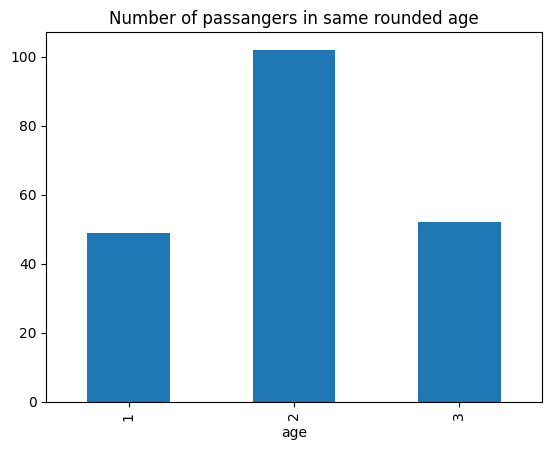

In [56]:
import matplotlib
import matplotlib.pyplot as plt

s = df_age.groupby('age')['ID'].nunique()
s.plot.bar(title='Number of passangers in same rounded age')

In [57]:
# na závěr sloučím tabulku s vyplněným věkem a tabulku s napredikovaným věkem
df_final = pd.concat([df_age, df_filled_age])

In [58]:
# zkontoluji data, že vše proběhlo jak má, nikde nejsou chybějící honoty nebo jiné nestovnalost
df_final.head(998)

,ID,survived,pclass,sex,age,sibsp,parch,ticket,fare,embarked
2,2,0,2,1,2,0,0,32,0.0000,2
5,5,0,3,1,2,0,0,52,7.2292,0
16,16,1,2,1,1,0,0,167,13.8625,0
26,26,1,3,0,2,0,2,50,22.3583,0
36,36,1,3,0,2,1,0,108,15.5000,1
...,...,...,...,...,...,...,...,...,...,...
990,990,1,3,0,1,1,1,532,16.7000,3
991,991,0,3,0,2,1,0,580,7.9250,3
992,992,0,3,1,2,0,0,244,8.6625,3
995,995,1,1,0,2,0,0,34,151.5500,3


Na závěr zkontroluji, zda někde nejsou chybějící hodnoty nebo nenumerické datové typy a udělám si kopii dataframu pro finální odevzdání.

In [23]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 2 to 999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1000 non-null   int64  
 1   survived  1000 non-null   int64  
 2   pclass    1000 non-null   int64  
 3   sex       1000 non-null   int8   
 4   age       1000 non-null   int64  
 5   sibsp     1000 non-null   int64  
 6   parch     1000 non-null   int64  
 7   ticket    1000 non-null   int16  
 8   fare      1000 non-null   float64
 9   embarked  1000 non-null   int8   
dtypes: float64(1), int16(1), int64(6), int8(2)
memory usage: 66.4 KB


## Predikování pomocí klasifikačního stromu

Jako první budu vytvářet dva modely pomocí klasifikačního rozhodovacího stromu s různými kritérii. Připravím si Xdata(data s příznaky na základě, kterých chceme predikovat příznak "survived") a ydata (obsahující pouze jeden sloupec "survived", na kterém budu porovnávat výsledek)

In [59]:
Xdata = df_final.drop(labels=["survived"], axis=1)
ydata = df_final.survived

Nyní si rozdělím data na trénovací, testovací a validační množinu. Volím rozdělení: 0.5 - trénovací, 0.25 - testovací, 0.25 - validační.

In [60]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.5, random_state=333)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=333) 

### Použití gini indexu

Pro natrénování modelu použiji metodu z sklearn DecisionTreeClassifier. Jako kritérium zvolím gini index (je v defaultním nastavení, nebudu ho explicitně vypisovat). Hyperparametr max_depth nastavím na 50, protože to už je dostatečná hloubka, při které by měla být úspěšnost na trénovací množině vysoká.  Pro zjištění přesnosti použiji funkci metrics z sklearn.

In [61]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

clf_gini = DecisionTreeClassifier(max_depth = 50)
clf_gini.get_params()

clf_gini.fit(Xtrain, ytrain)

print("Accuracy - train: {0:.10f}".format(metrics.accuracy_score(ytrain, clf_gini.predict(Xtrain))))
print("Accuracy - test: {0:.10f}".format(metrics.accuracy_score(ytest, clf_gini.predict(Xtest))))
print("Accuracy - val: {0:.10f}".format(metrics.accuracy_score(yval, clf_gini.predict(Xval))))

Accuracy - train: 1.0000000000
Accuracy - test: 0.7400000000
Accuracy - val: 0.7440000000


 Na trénovací množině je přesnost 100%, na testovací se blíží k 75%, občas je překročí. To není ideální výsledek.

Pomocí matplotlib si vykreslím graf, ve kterém je vidět, jak se mění přesnost v závislosti na hyperparametru depth (hloubky stromu).  

In [62]:
val_accuracy = []
train_accuracy = []
depths = range(1,50)
for depth in depths:
    clf_gini = DecisionTreeClassifier(max_depth=depth)
    clf_gini.fit(Xtrain, ytrain)
    train_accuracy.append(metrics.accuracy_score(ytrain, clf_gini.predict(Xtrain)))
    val_accuracy.append(metrics.accuracy_score(yval, clf_gini.predict(Xval)))

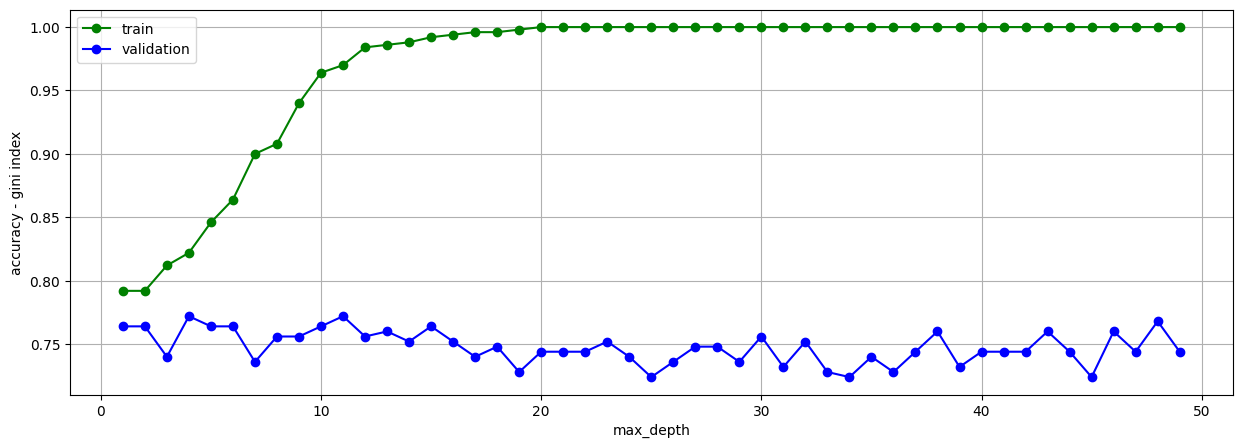

In [63]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(depths, train_accuracy,"og-")
plt.plot(depths, val_accuracy,"ob-")
plt.grid(True)
plt.xlabel("max_depth")
plt.ylabel("accuracy - gini index")
plt.legend(["train", "validation"])

### Použití entropie

Nyní použiji opět klasifikační strom, ale změním hyperparametr: kritérium na entropii. Je vidět, že přesnost je velmi podobná jako u gini indexu.

In [64]:
clf_entropy = DecisionTreeClassifier(criterion="entropy", max_depth = 50)

clf_entropy.get_params()
clf_entropy.fit(Xtrain, ytrain)

print("Accuracy - train: {0:.10f}".format(metrics.accuracy_score(ytrain, clf_entropy.predict(Xtrain))))
print("Accuracy - test: {0:.10f}".format(metrics.accuracy_score(ytest, clf_entropy.predict(Xtest))))

Accuracy - train: 1.0000000000
Accuracy - test: 0.7400000000


Pro porovnání si vykreslím stejný graf jako pro gini index, porovnávající přesnost a hyperparametr depths, pro entropii. I z grafu je vidět, že zvolením jiného kritéria se výsledek rapidně nezmění. 

In [65]:
val_accuracy = []
train_accuracy = []
depths = range(1,50)
for depth in depths:
    clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    clf_entropy.fit(Xtrain, ytrain)
    train_accuracy.append(metrics.accuracy_score(ytrain, clf_entropy.predict(Xtrain)))
    val_accuracy.append(metrics.accuracy_score(yval, clf_entropy.predict(Xval)))

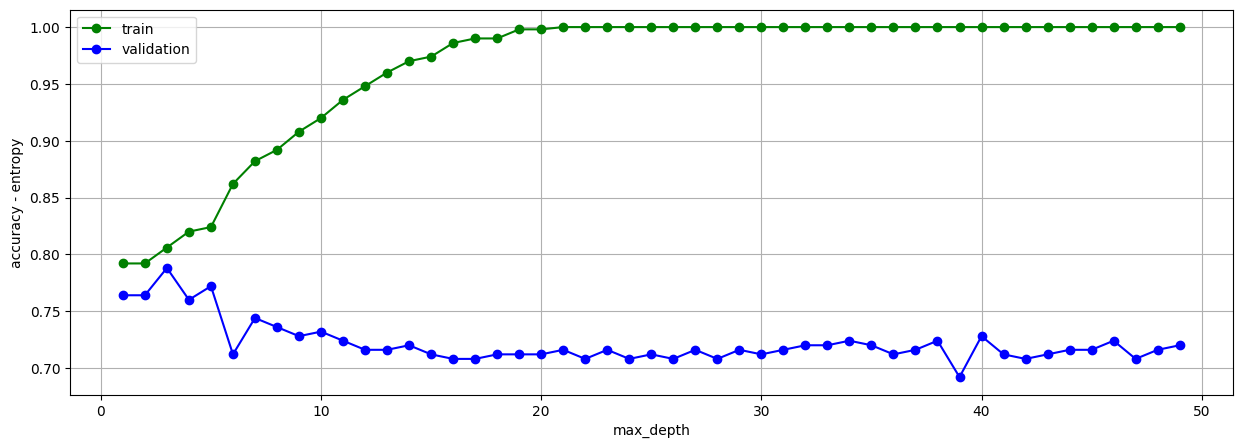

In [66]:
plt.figure(figsize=(15,5))
plt.plot(depths, train_accuracy,"og-")
plt.plot(depths, val_accuracy,"ob-")
plt.grid(True)
plt.xlabel("max_depth")
plt.ylabel("accuracy - entropy")
plt.legend(["train", "validation"])

## Predikování pomocí metody kNN

Tentokrát budu trénovat model pomocí metody nejbližších sousedů. Rozdělím si množiny ve stejném poměru jako při rozhodovacích stromech.

In [67]:
Xdata = df_final.drop(labels=["survived"], axis=1)
ydata = df_final.survived

In [68]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.5, random_state=333)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=333) 

Naimportuji si funkci KNeighborsClassifier z sklearn, která natrénuje model. 

In [69]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

clf_kNN = KNeighborsClassifier(n_neighbors = 8)
clf_kNN.fit(Xtrain, ytrain)

print("Accuracy - train: {0:.10f}".format(metrics.accuracy_score(ytrain, clf_kNN.predict(Xtrain))))
print("Accuracy - test: {0:.10f}".format(metrics.accuracy_score(ytest, clf_kNN.predict(Xtest))))

Accuracy - train: 0.6820000000
Accuracy - test: 0.5760000000


Výsledek není ani zdaleka dobrý. Necelá 60% úspěšnost na testovací množině není přijatelná. Zkusím tedy data standardizovat pomocí StandardScaler. Hyperparametr n_neighbours nastavím na 14, protože z následujícího grafu je vidět, že má nejlepší přesnost.

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest)
Xval_scaled = scaler.fit_transform(Xval)

clf_kNN_scaled = KNeighborsClassifier(n_neighbors = 14)
clf_kNN_scaled.fit(Xtrain_scaled, ytrain)

print("Accuracy - train: {0:.10f}".format(metrics.accuracy_score(ytrain, clf_kNN_scaled.predict(Xtrain_scaled))))
print("Accuracy - train: {0:.10f}".format(metrics.accuracy_score(ytest, clf_kNN_scaled.predict(Xtest_scaled))))
print("Accuracy - val: {0:.10f}".format(metrics.accuracy_score(yval, clf_kNN_scaled.predict(Xval_scaled))))


Accuracy - train: 0.8040000000
Accuracy - train: 0.7960000000
Accuracy - val: 0.8000000000


Je vidět, že úprava dat pomocí StandartScaler trochu pomohla. Na závěr si vkreslím obdobný graf jako u klasifikačních stromů, avšak ve vstahu k hyperparametru "sousedů". 

In [71]:
kNN_val_accuracy = []
kNN_train_accuracy = []

kneighbors = range(1,50)
for k in kneighbors:
    clf_kNN_scaled = KNeighborsClassifier(n_neighbors = k)
    clf_kNN_scaled.fit(Xtrain_scaled, ytrain)
    kNN_val_accuracy.append(clf_kNN_scaled.score(Xval_scaled, yval))
    kNN_train_accuracy.append(clf_kNN_scaled.score(Xtrain_scaled, ytrain))

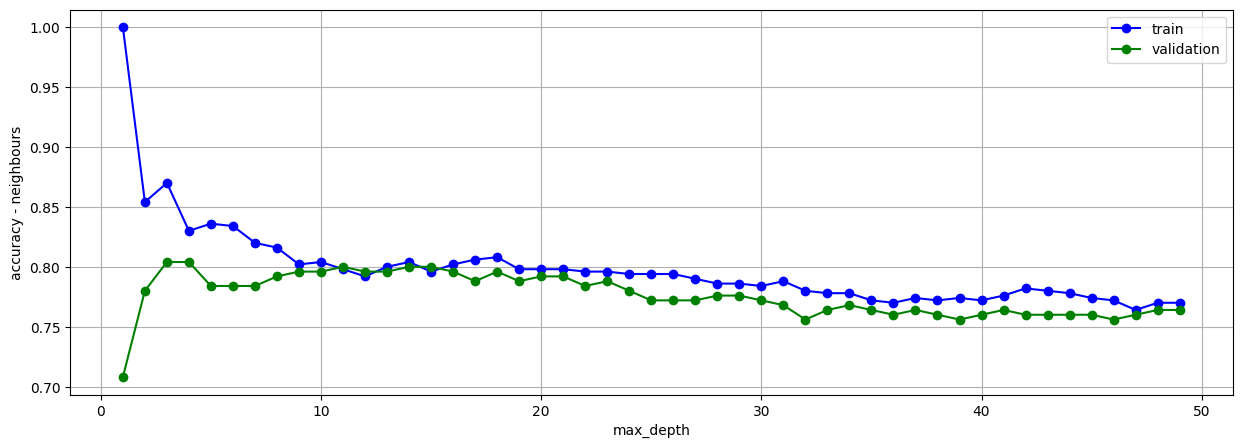

In [73]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(kneighbors, kNN_train_accuracy,"ob-")
plt.plot(kneighbors, kNN_val_accuracy,"og-")
plt.grid(True)
plt.xlabel("max_depth")
plt.ylabel("accuracy - neighbours")
plt.legend(["train", "validation"])

Metoda nejbližších sousedu se standardizací dat vypadá, že dopadla nejlépe a tak ji použij pro predikci na datech evaluation.csv. Zopakuji celý proces přípravy dat, včetně doplnění věku pomocí rozhodovacího stromu, následně data standardizuji a použiji natrénovaný model s metodou nejmenších čtverců pro standardizovaná data.

In [78]:
data_for_eval = pd.read_csv("evaluation.csv")

age_category(data_for_eval)

# nejdříve nahradím chybějící hodnoty na -1
data_for_eval["fare"].fillna(-1, inplace=True)
data_for_eval["embarked"].fillna(-1, inplace=True)

# zde odstraňuji nepotřebné sloupce
data_for_eval.drop(labels=["cabin"], axis=1, inplace=True)
data_for_eval.drop(labels=["home.dest"], axis=1, inplace=True)
data_for_eval.drop(labels=["name"], axis=1, inplace=True)

# vytvořím si dva datasety s vyplněným věkem, res. nevyplněným věkem
df_filled_age_final = data_for_eval.dropna(subset=["age"]).copy()
df_filled_age_final["age"] = df_filled_age_final["age"].astype("int")
df_not_filled_age_final = data_for_eval[data_for_eval.age.isna()].copy()

# přetypuji sloupce s nenumerickým datovým typem
objects = df_filled_age_final.select_dtypes(['object']).columns
df_filled_age_final[objects] = df_filled_age_final[objects].astype('category').apply(lambda x: x.cat.codes)

objects = df_not_filled_age_final.select_dtypes(['object']).columns
df_not_filled_age_final[objects] = df_not_filled_age_final[objects].astype('category').apply(lambda x: x.cat.codes)

# odsraním sloupec hledané proměnné, v tomoto případě sloupec s hodnotami nan
df_not_filled_age_final = df_not_filled_age_final.drop(labels=["age"], axis=1)

# připravím si datasety X y, doplním si je o původní data s vyplněným věkem ať zvýším pravděpodobnost úspěchu.
# nicméně musím odstranit sloupec "survived", protože ten v datech evaluation.csv není
Xdata_age_final = pd.concat([df_filled_age_final.drop(labels=["age"], axis=1), Xdata_age.drop(labels=["survived"], axis=1)])
ydata_age_final = pd.concat([df_filled_age_final.age, df_filled_age.age])

In [79]:
Xdata_age_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1046 non-null   int64  
 1   pclass    1046 non-null   int64  
 2   sex       1046 non-null   int8   
 3   sibsp     1046 non-null   int64  
 4   parch     1046 non-null   int64  
 5   ticket    1046 non-null   int16  
 6   fare      1046 non-null   float64
 7   embarked  1046 non-null   int8   
dtypes: float64(1), int16(1), int64(4), int8(2)
memory usage: 53.1 KB


In [80]:
# rozdělím si data na trénovací a testovací množinu
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata_age_final, ydata_age_final, test_size=0.3, random_state=333)

# natrénuji znova klasifikační strom podle 
clf_age_final = DecisionTreeClassifier(max_depth = 50)
clf_age_final.get_params()

clf_age_final.fit(Xtrain, ytrain)

print("Accuracy - train: {0:.10f}".format(metrics.accuracy_score(ytrain, clf_age_final.predict(Xtrain))))
print("Accuracy - test: {0:.10f}".format(metrics.accuracy_score(ytest, clf_age_final.predict(Xtest))))

Accuracy - train: 1.0000000000
Accuracy - test: 0.5477707006


In [81]:
df_age = pd.DataFrame({"ID": df_not_filled_age_final.ID,
                "pclass" : df_not_filled_age_final.pclass,
                "sex" : df_not_filled_age_final.sex,
                "age": clf_age_final.predict(df_not_filled_age_final),
                "sibsp" : df_not_filled_age_final.sibsp,
                "parch" : df_not_filled_age_final.parch,
                "ticket" : df_not_filled_age_final.ticket,
                "fare" : df_not_filled_age_final.fare,
                "embarked" : df_not_filled_age_final.embarked})
data_for_eval_final = pd.concat([df_age, df_filled_age_final])

In [82]:
data_for_eval_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 4 to 308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        309 non-null    int64  
 1   pclass    309 non-null    int64  
 2   sex       309 non-null    int8   
 3   age       309 non-null    int64  
 4   sibsp     309 non-null    int64  
 5   parch     309 non-null    int64  
 6   ticket    309 non-null    int16  
 7   fare      309 non-null    float64
 8   embarked  309 non-null    int8   
dtypes: float64(1), int16(1), int64(5), int8(2)
memory usage: 18.1 KB


Na závěr napredikuji data a uložím je do souboru result.csv. Ověření správnosti je v tuto chvíli s dostupnými prostředky složié. Avšak za předpokladu, že poměr přežití a úmrtí se v datatsetech podobný, vyjádřím si procento přeživších na původních a výsledných datech. Je vidět, že přežila (velmi)zhruba jedna třetina lidí v obou množinách, z čehož lze usoudit, že výsledek by mohl být správný. 

In [83]:
data_for_eval_scaled = scaler.fit_transform(data_for_eval_final)
result = pd.DataFrame({"ID" : data_for_eval_final.ID, "survived" : clf_kNN_scaled.predict(data_for_eval_scaled)})
result.to_csv("result.csv", index=False)

print("Test data:")
print((df_final['survived'].value_counts()/df_final['survived'].count())*100)
print("Result data:")
print((result['survived'].value_counts()/result['survived'].count())*100)



Test data:
0    60.9
1    39.1
Name: survived, dtype: float64
Result data:
0    66.990291
1    33.009709
Name: survived, dtype: float64


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b59b7adb-4163-4ef0-9bea-ec8be4e10f4a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>